<a href="https://colab.research.google.com/github/Pragna235/ACM-Winter-School-2023-Hands-on-Labs/blob/main/Lab_4_Sentiment_Analysis_of_Tweets_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing dependencies

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
# import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# %matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Data and preprocess

In [8]:
# Load Tweet dataset
df = pd.read_csv('Twitter_Data.csv')
# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


In [9]:
# dimensionality of the data
df.shape

(42659, 2)

In [10]:
# Check for missing data
df.isnull().sum()

clean_text    1
category      0
dtype: int64

In [11]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [12]:
# dimensionality of the data
df.shape

(42658, 2)

In [13]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


### Data Analysis

In [14]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

In [15]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

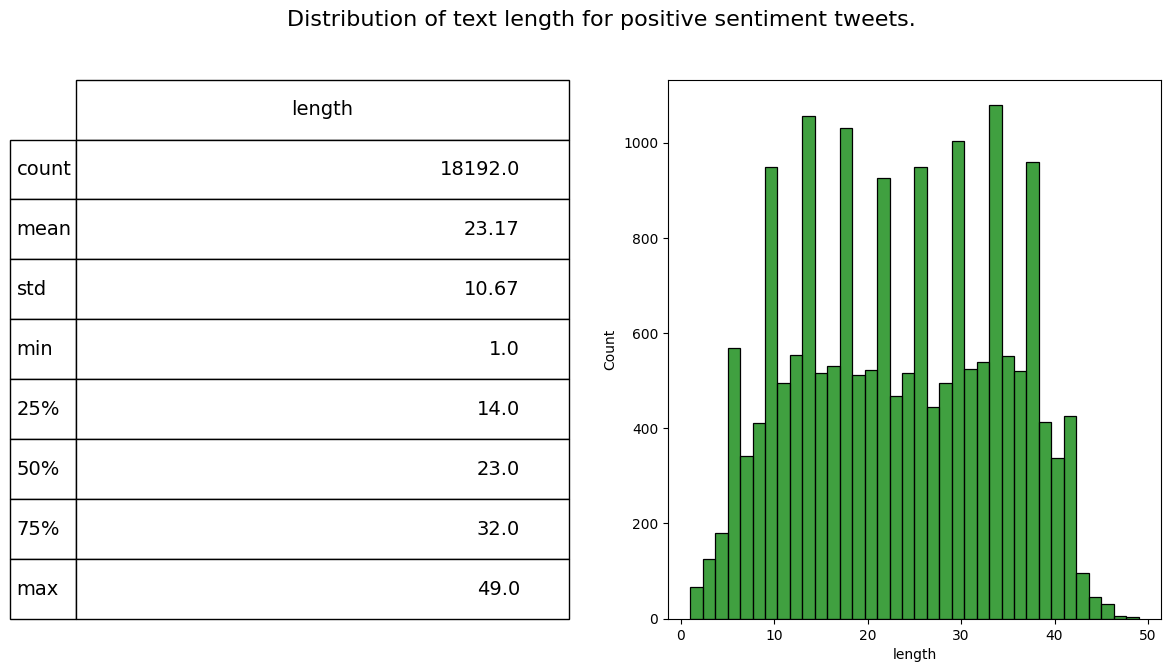

In [25]:
# Plotting the distribution of text length for positive sentiment tweets.
fig = plt.figure(figsize=(14,7))
# Add a new column 'length' to the DataFrame (df), which contains the number of words in each tweet after splitting the text.
df['length'] = df.clean_text.str.split().apply(len)
# Set up two subplots: one with subplot index 122 (right side) and another with subplot index 121 (left side).
ax1 = fig.add_subplot(122)
# Plot a histogram using seaborn (sns) for the lengths of tweets with positive sentiment ('Positive'). The histogram is shown on the subplot (ax1) with a green color.
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
# Calculate descriptive statistics (mean, std, min, 25%, 50%, 75%, max) for the lengths of positive sentiment tweets and rounds the values to two decimal places.
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

# Set up a table on the subplot (ax2) displaying the descriptive statistics for positive sentiment tweet lengths. The table is positioned to cover the entire subplot, and the font size is set to 14.
ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)

fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

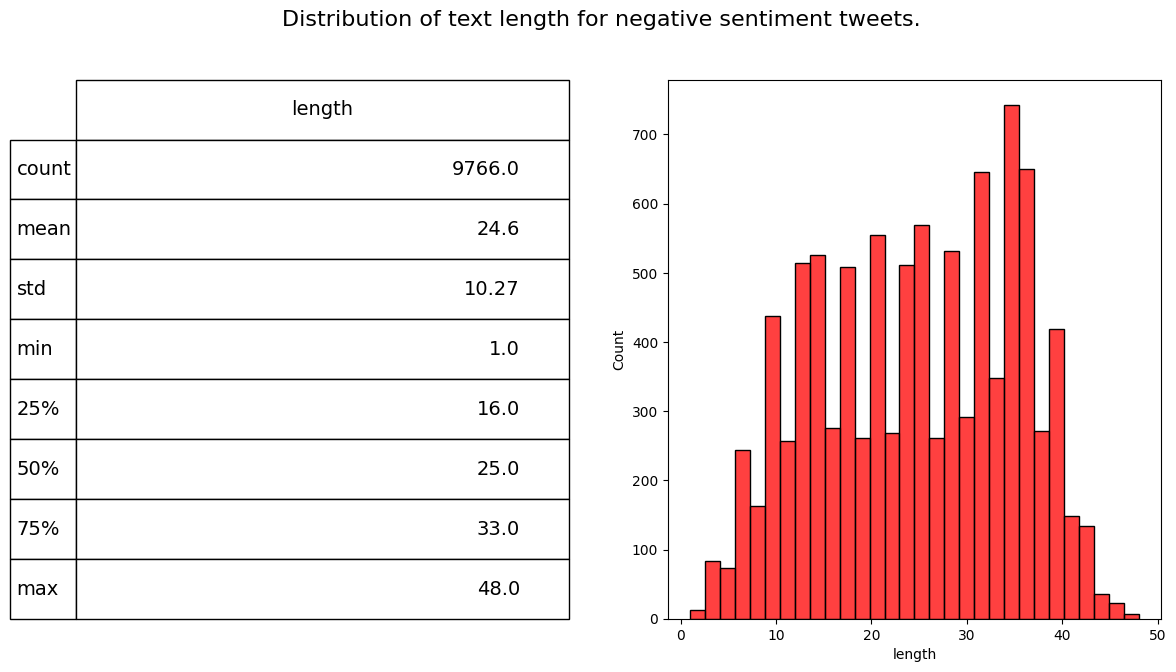

In [26]:
# Plotting the distribution of text length for negative sentiment tweets.
fig = plt.figure(figsize=(14,7))
# Add a new column 'length' to the DataFrame (df), which contains the number of words in each tweet after splitting the text.
df['length'] = df.clean_text.str.split().apply(len)
# Set up two subplots: one with subplot index 122 (right side) and another with subplot index 121 (left side).
ax1 = fig.add_subplot(122)
# Plot a histogram using seaborn (sns) for the lengths of tweets with positive sentiment ('Positive'). The histogram is shown on the subplot (ax1) with a green color.
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
# Calculate descriptive statistics (mean, std, min, 25%, 50%, 75%, max) for the lengths of positive sentiment tweets and rounds the values to two decimal places.
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

# Set up a table on the subplot (ax2) displaying the descriptive statistics for positive sentiment tweet lengths. The table is positioned to cover the entire subplot, and the font size is set to 14.
ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)

fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

In [27]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [29]:
df.head()

,clean_text,category,length
0,when modi promised “minimum government maximum...,Negative,33
1,talk all the nonsense and continue all the dra...,Neutral,13
2,what did just say vote for modi welcome bjp t...,Positive,22
3,asking his supporters prefix chowkidar their n...,Positive,34
4,answer who among these the most powerful world...,Positive,14


In [30]:
df.drop(['length'], axis=1, inplace=True)
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


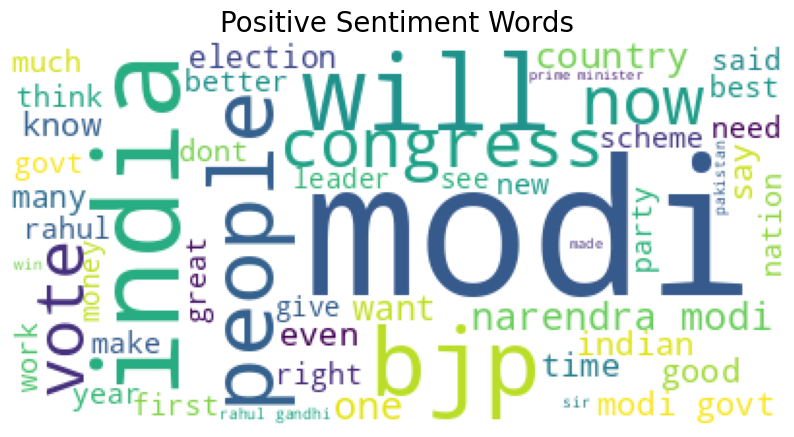

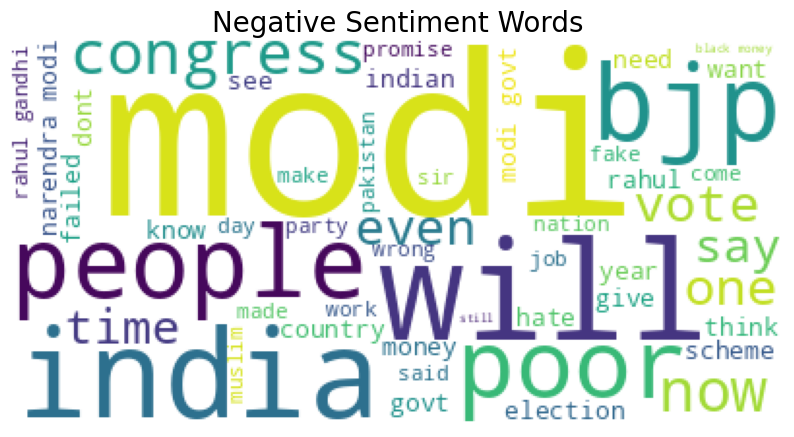

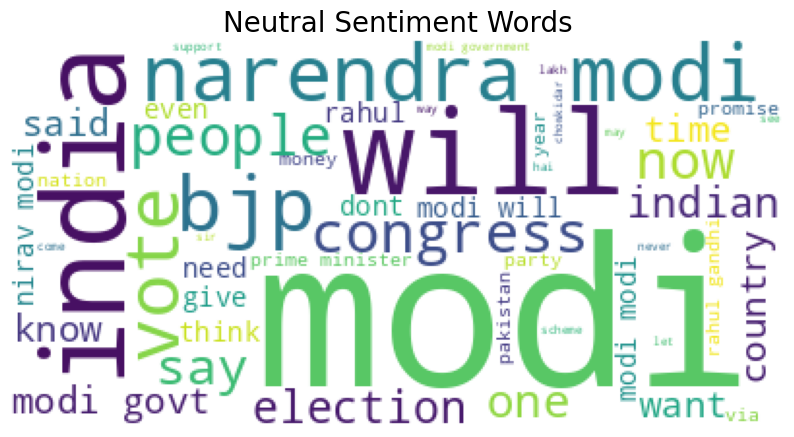

In [31]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets of the input category
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(df, 'Positive')

# Negative tweet words
wordcount_gen(df, 'Negative')

# Neutral tweet words
wordcount_gen(df, 'Neutral')


### Data Preprocessing

In [32]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")] #Removes common English stopwords (e.g., "the," "and," "is") from the list of words. This step helps focus on more meaningful words for analysis.
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words] #Applies stemming using the Porter Stemmer algorithm to reduce words to their root or base form. Stemming helps consolidate variations of words into a common form.
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [33]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))
X

[['modi',
  'promis',
  'minimum',
  'govern',
  'maximum',
  'govern',
  'expect',
  'begin',
  'difficult',
  'job',
  'reform',
  'state',
  'take',
  'year',
  'get',
  'justic',
  'state',
  'busi',
  'exit',
  'psu',
  'templ'],
 ['talk', 'nonsens', 'continu', 'drama', 'vote', 'modi'],
 ['say',
  'vote',
  'modi',
  'welcom',
  'bjp',
  'told',
  'rahul',
  'main',
  'campaign',
  'modi',
  'think',
  'modi',
  'relax'],
 ['ask',
  'support',
  'prefix',
  'chowkidar',
  'name',
  'modi',
  'great',
  'servic',
  'confus',
  'read',
  'crustal',
  'clear',
  'crass',
  'filthi',
  'nonsens',
  'see',
  'abus',
  'come',
  'chowkidar'],
 ['answer',
  'among',
  'power',
  'world',
  'leader',
  'today',
  'trump',
  'putin',
  'modi',
  'may'],
 ['kiya', 'tho', 'refresh', 'maarkefir', 'comment', 'karo'],
 ['surat',
  'women',
  'perform',
  'yagna',
  'seek',
  'divin',
  'grace',
  'narendra',
  'modi',
  'becom'],
 ['come',
  'cabinet',
  'scholar',
  'like',
  'modi',
  'smriti

In [34]:
print(len(X))

42658


In [35]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [36]:
print(df['clean_text'][0])
print(X[0])
print(df['category'][0])
print(Y[0])

when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']
Negative
0


### Tokenizing & Padding

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of integers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  46    1  144   76 1730 1001   42 2415    2 1275  206    2  205   34
  160  127   50   67  820  205   55    3    7  495    3   55 3226    3
 2623    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Saving tokenized data

In [39]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Train & Test Split

In [40]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(type(X_train),type(y_train))
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>
Train Set -> (25594, 50) (25594, 3)
Validation Set -> (8532, 50) (8532, 3)
Test Set -> (8532, 50) (8532, 3)


In [41]:
# import keras.backend as K

# def f1_score(precision, recall):
#     ''' Function to calculate f1 score '''

#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

### Model

In [42]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, SimpleRNN
# from keras.metrics import Precision, Recall
# from keras.optimizers import SGD
# from keras.optimizers import RMSprop
# from keras import datasets

# from keras.callbacks import LearningRateScheduler
# from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=10
learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8

# sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
# model= Sequential()
# model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(32)))
# model.add(Dropout(0.4))
# model.add(Dense(3, activation='softmax'))

model = Sequential()

model.add(Embedding(vocab_size,embedding_size,input_length =max_len)) # num_words=15000
model.add(SimpleRNN(16,input_shape = (vocab_size,max_len), return_sequences=False,activation="relu"))
model.add(Dense(3, activation='softmax'))



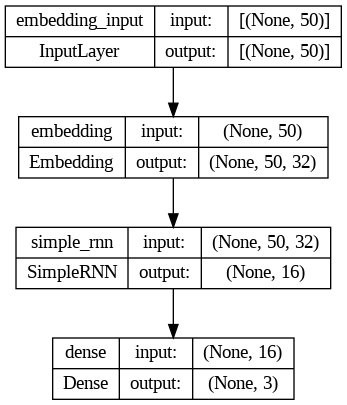

In [43]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [44]:
print(model.summary())


# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               metrics=['accuracy'])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 160835 (628.26 KB)
Trainable params: 160835 (628.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
400/400 [==============================] - 10s 16ms/step - loss: 1211932.2500 - accuracy: 0.3717 - val_loss: 116.3670 - val_accuracy: 0.3475
Epoch 2/10
400/400 [==============================] - 8s 19ms/step - loss: 57.3506 - accuracy: 0.3566 - val_loss: 43.8080 -

### Model Accuracy & Loss

In [45]:
# Evaluate model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print(score)

[4.5721025466918945, 0.40775901079177856]


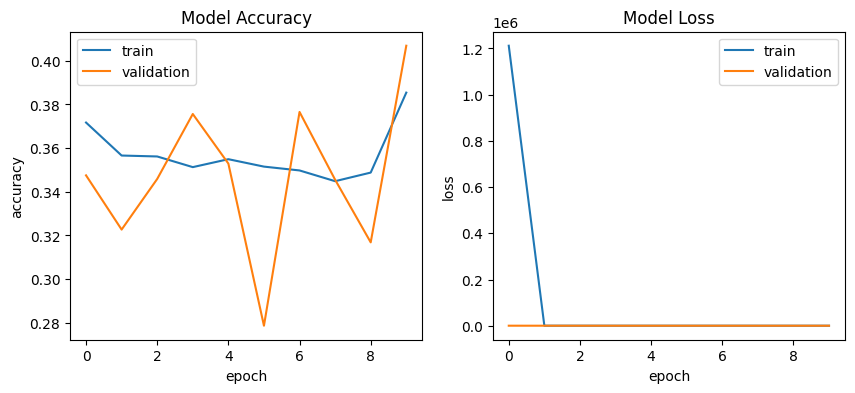

In [46]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

LSTM

In [47]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, SimpleRNN
# from keras.metrics import Precision, Recall
# from keras.optimizers import SGD
# from keras.optimizers import RMSprop
# from keras import datasets

# from keras.callbacks import LearningRateScheduler
# from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=10
learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8

# sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
# model= Sequential()
# model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(32)))
# model.add(Dropout(0.4))
# model.add(Dense(3, activation='softmax'))

model = Sequential()

model.add(Embedding(vocab_size,embedding_size,input_length =max_len)) # num_words=15000
model.add(LSTM(16))
model.add(Dense(3, activation='softmax'))



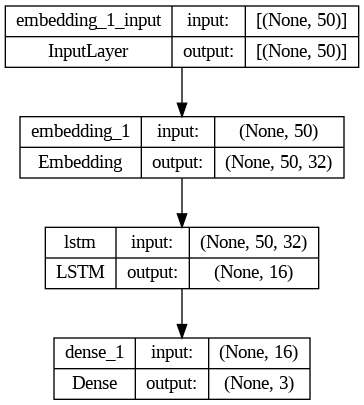

In [48]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [49]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               metrics=['accuracy'])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 32)            160000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 163187 (637.45 KB)
Trainable params: 163187 (637.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
400/400 [==============================] - 14s 28ms/step - loss: 1.0759 - accuracy: 0.4125 - val_loss: 1.0811 - val_accuracy: 0.4238
Epoch 2/10
400/400 [==============================] - 11s 27ms/step - loss: 1.0732 - accuracy: 0.4141 - val_loss: 1.0739 - val_ac

### Model Accuracy

In [50]:
# Evaluate model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print(score)

[1.0684658288955688, 0.4302625358104706]


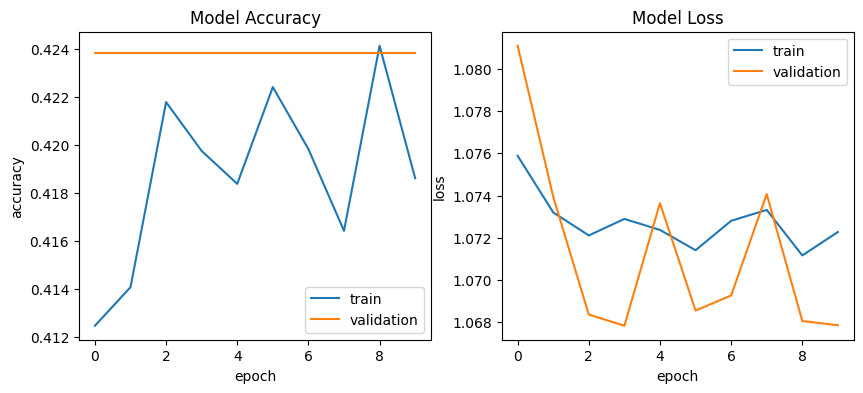

In [51]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

### GRU

In [52]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, SimpleRNN, GRU
# from keras.metrics import Precision, Recall
# from keras.optimizers import SGD
# from keras.optimizers import RMSprop
# from keras import datasets

# from keras.callbacks import LearningRateScheduler
# from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=10
learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8

# sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
# model= Sequential()
# model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(32)))
# model.add(Dropout(0.4))
# model.add(Dense(3, activation='softmax'))

model = Sequential()

model.add(Embedding(vocab_size,embedding_size,input_length =max_len)) # num_words=15000
model.add(GRU(16))
model.add(Dense(3, activation='softmax'))



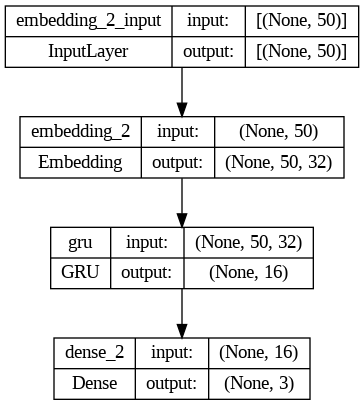

In [53]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               metrics=['accuracy'])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            160000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 162451 (634.57 KB)
Trainable params: 162451 (634.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
400/400 [==============================] - 15s 31ms/step - loss: 0.8275 - accuracy: 0.6616 - val_loss: 0.7077 - val_accuracy: 0.7650
Epoch 2/10
400/400 [==============================] - 11s 28ms/step - loss: 0.6779 - accuracy: 0.7583 - val_loss: 0.6685 - val_ac

### Model Accuracy

In [55]:
# Evaluate model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print(score)

[0.7997804880142212, 0.680262565612793]


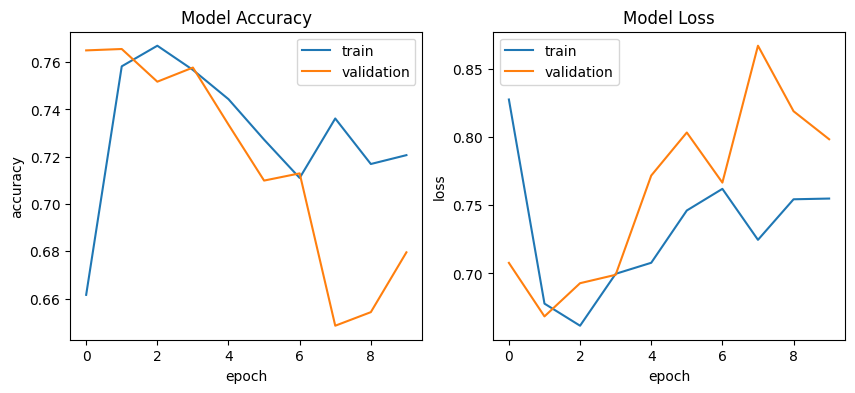

In [56]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

### RNN,LSTM, GRU https://medium.com/@saurabh.rathor092/simple-rnn-vs-gru-vs-lstm-difference-lies-in-more-flexible-control-5f33e07b1e57

#### MNIST Dataset

In [57]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# compute the number of labels
num_labels = len(np.unique(y_train))

print(type(x_train[0]))
im = Image.fromarray(x_train[0])
print(x_train.shape)
print(y_train[0])
display(im)




11490434/11490434 [==============================] - 0s 0us/step
<class 'numpy.ndarray'>
(60000, 28, 28)
5


In [58]:
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# resize and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size])
x_test = np.reshape(x_test,[-1, image_size, image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size)
batch_size = 128
units = 256

# model is RNN with 256 units, input is 28-dim vector 28 timesteps
model = Sequential(name='SimpleRNN_MNIST')
model.add(SimpleRNN(units=units,
                    input_shape=input_shape))
model.add(Dense(num_labels, activation='softmax'))
model.summary()

# loss function for one-hot vector
# use of sgd optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
# train the network
model.fit(x_train, y_train, epochs=10, batch_size=batch_size)

loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Model: "SimpleRNN_MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 256)               72960     
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 75530 (295.04 KB)
Trainable params: 75530 (295.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 24s 49ms/step - loss: 0.6636 - accuracy: 0.8219
Epoch 2/10
469/469 [==============================] - 24s 50ms/step - loss: 0.2705 - accuracy: 0.9226
Epoch 3/10
469/469 [==============================] - 23s 50ms/step - loss: 0.1908 - accuracy: 0.9440
Epoch 4/10
469/469 [==============================] - 22s 47ms/step - loss: 0.1586 - accuracy: 0.9538
E